In [2]:
import cv2
import math
import copy
import numpy as np
import matplotlib.pyplot as plt

### 1. Load the chromophobe-renal-cell-carcinoma image

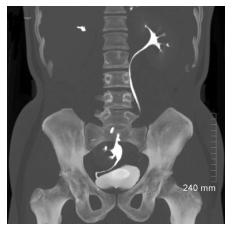

In [3]:
renalcell_img = cv2.imread('chromophobe-renal-cell-carcinoma-6.jpg', 0)
## disable x & y axis
plt.axis('off')
plt.imshow(renalcell_img, cmap='gray', vmin=renalcell_img.min(), vmax=renalcell_img.max())

### 2. Design an interface to obtain the initial contour from user's clicks

In [4]:
renalcell_points = []  
renalcell_img_copy = copy.deepcopy(renalcell_img)

In [5]:
def mouse_click(event, x, y, flags, params):
    # Check whether left mouse button was clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(params[0], (x, y), 5, (255, 0, 0), -1)
        cv2.imshow(params[1], params[0])
        params[2].append([x, y])
        print(params[2])

In [6]:
cv2.namedWindow('Renal Cell Image')
cv2.setMouseCallback('Renal Cell Image', mouse_click, (renalcell_img_copy, 'Renal Cell Image', renalcell_points))
cv2.imshow('Renal Cell Image', renalcell_img_copy)
cv2.waitKey(0)

[[653, 230]]
[[653, 230], [622, 255]]
[[653, 230], [622, 255], [597, 296]]
[[653, 230], [622, 255], [597, 296], [601, 334]]
[[653, 230], [622, 255], [597, 296], [601, 334], [607, 384]]
[[653, 230], [622, 255], [597, 296], [601, 334], [607, 384], [612, 425]]
[[653, 230], [622, 255], [597, 296], [601, 334], [607, 384], [612, 425], [610, 473]]
[[653, 230], [622, 255], [597, 296], [601, 334], [607, 384], [612, 425], [610, 473], [657, 469]]
[[653, 230], [622, 255], [597, 296], [601, 334], [607, 384], [612, 425], [610, 473], [657, 469], [699, 440]]
[[653, 230], [622, 255], [597, 296], [601, 334], [607, 384], [612, 425], [610, 473], [657, 469], [699, 440], [758, 435]]
[[653, 230], [622, 255], [597, 296], [601, 334], [607, 384], [612, 425], [610, 473], [657, 469], [699, 440], [758, 435], [804, 469]]
[[653, 230], [622, 255], [597, 296], [601, 334], [607, 384], [612, 425], [610, 473], [657, 469], [699, 440], [758, 435], [804, 469], [814, 504]]
